In [1]:
from region_generator import create_puzzle
import jax.random as jr
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from functools import partial

import jax.random as jr
colors = jnp.array([
        [0, 0, 0],   # Red
        [0, 1, 0],   # Green
        [0, 0, 1],   # Blue
        [1, 1, 0],   # Yellow
        [1, 0, 1],   # Magenta
    ])

def plt_imshow(puzzle, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Initialize blank RGB image
    H, W = puzzle.shape[1], puzzle.shape[2]
    rgb_image = jnp.zeros((H, W, 3))

    # Add each mask's color where it's True
    for i in range(puzzle.shape[0]):
        mask = puzzle[i]  # shape (H, W)
        for c in range(3):
            rgb_image = rgb_image.at[:, :, c].add(mask * colors[i, c])

    # Clip to [0, 1] in case of overlapping True values
    rgb_image = jnp.clip(rgb_image, 0, 1)

    # Plot
    ax.imshow(rgb_image)
    ax.set_axis_off()

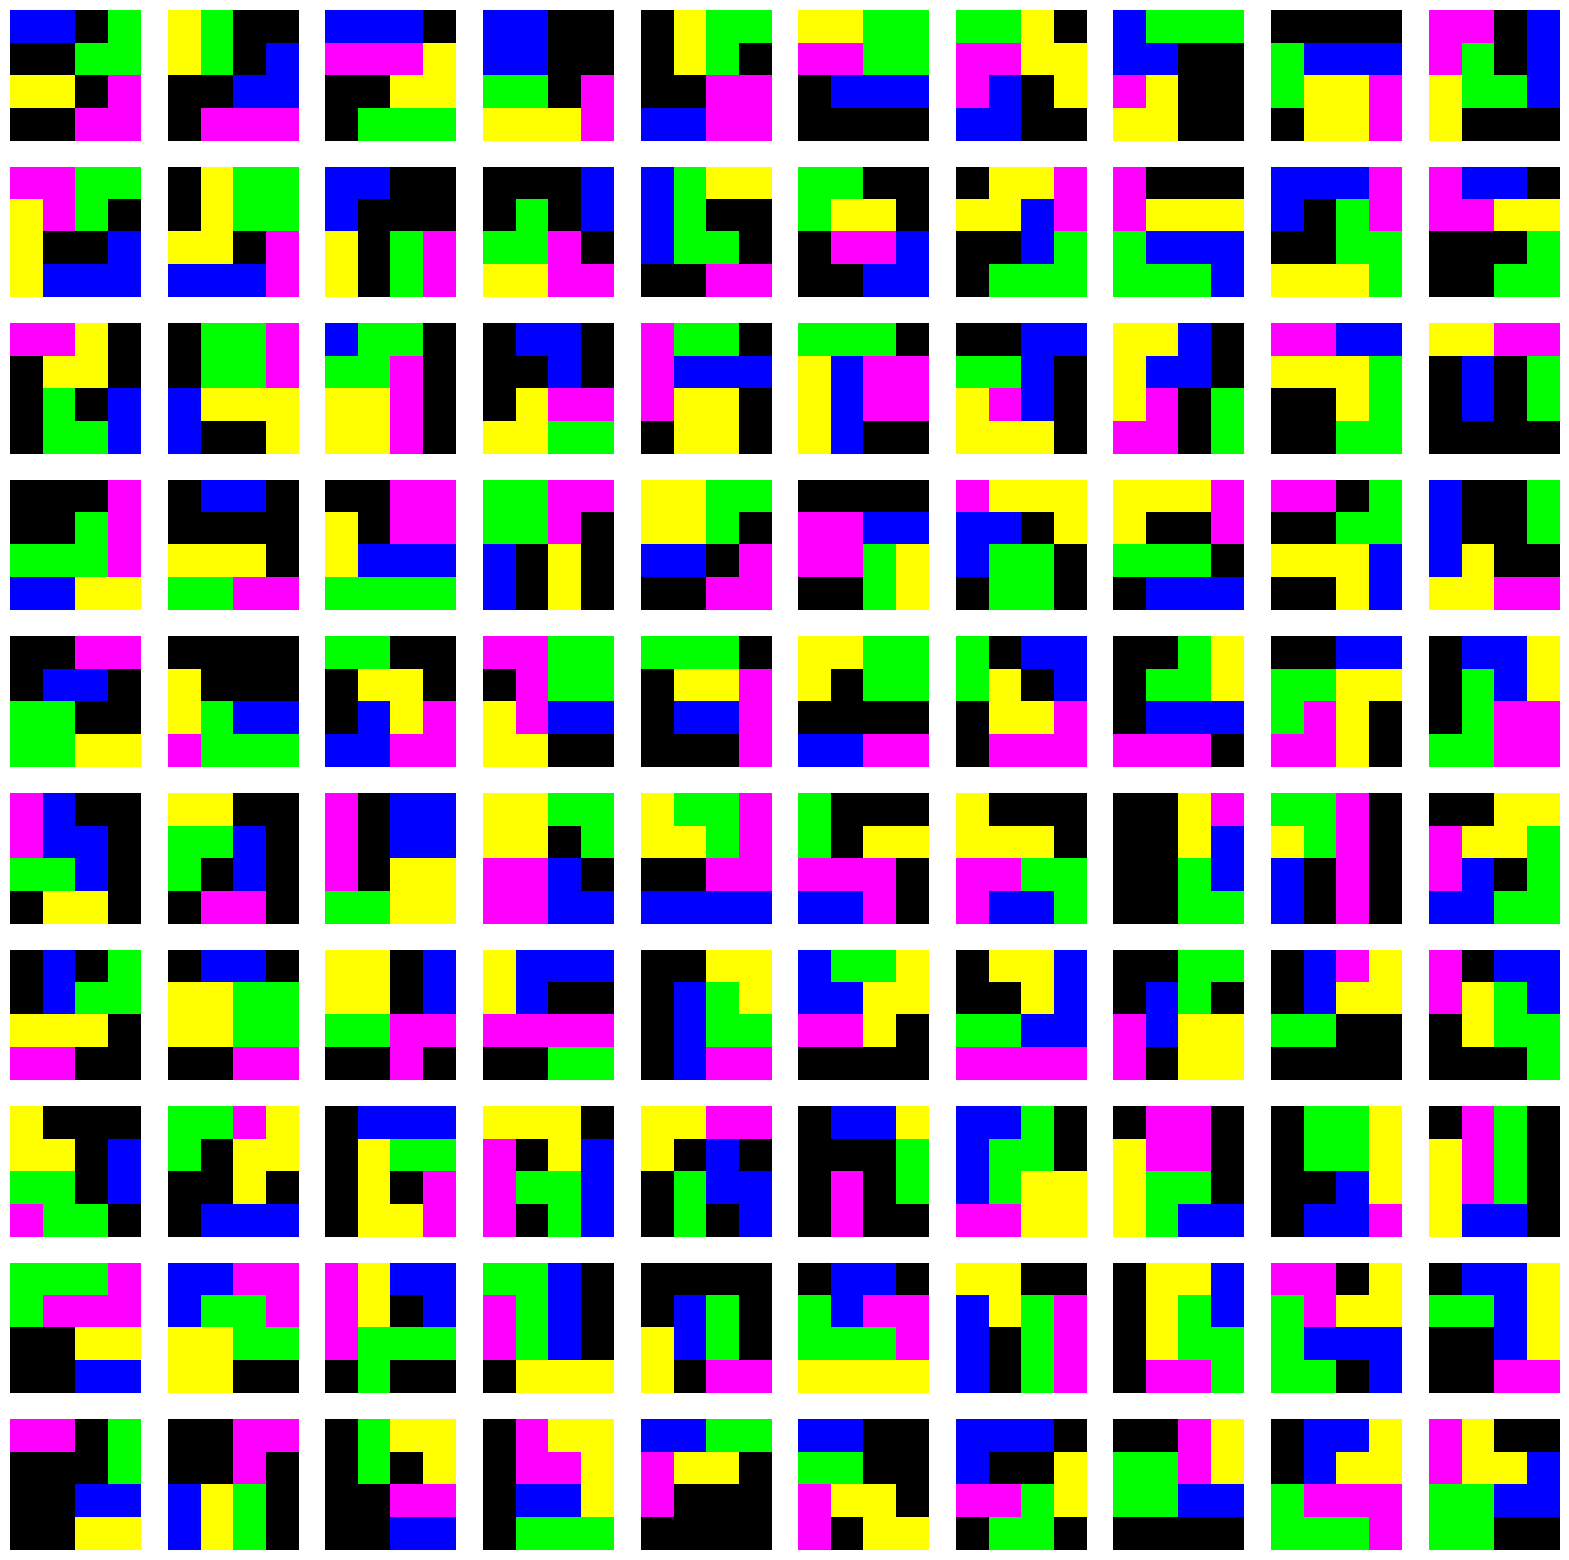

In [8]:
key = jr.key(5)
grid_size = 4

n = 10
fig, axes = plt.subplots(n, n, figsize=(n*2, n*2))
puzzle_fn = partial(create_puzzle, 
                    grid_size=4,
                    n_pieces=4,
                    min_piece_size=2,
                    max_piece_size=4,
                    )
puzzles = jax.vmap(puzzle_fn)(jr.split(key, n*n))
for i, (puzzle, ax) in enumerate(zip(puzzles, axes.flat)):
    plt_imshow(puzzle, ax=ax)

In [12]:
puzzle = puzzle.astype(jnp.float32)

In [ ]:
puzzle

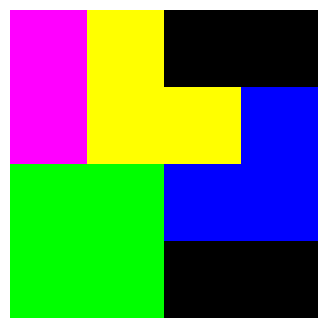

In [11]:
plt_imshow(puzzle)

In [ ]:

@jax.jit
def sample_coord(key, prob_matrix):
    # Flatten the 4x4 matrix
    probs_flat = prob_matrix.reshape(-1)
    path_grid = jnp.full_like(prob_matrix, 0.0)

    # Sample an index according to the probability distribution
    idx = jr.choice(key, a=probs_flat.shape[0], p=probs_flat)

    # Convert flat index back to (row, col)
    row = idx // prob_matrix.shape[1]
    col = idx % prob_matrix.shape[1]

    prob_matrix = prob_matrix.at[row, col].set(False)  # Set the sampled position to 0
    path_grid = path_grid.at[row, col].set(1.0)  # Mark the sampled position in the path grid

    return jnp.array([row, col]), prob_matrix, path_grid

In [ ]:
import jax.random as jr
colors = jnp.array([
        [0, 0, 0],   # Red
        [0, 1, 0],   # Green
        [0, 0, 1],   # Blue
        [1, 1, 0],   # Yellow
        [1, 0, 1],   # Magenta
    ])

def plt_imshow(puzzle, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Initialize blank RGB image
    H, W = puzzle.shape[1], puzzle.shape[2]
    rgb_image = jnp.zeros((H, W, 3))

    # Add each mask's color where it's True
    for i in range(puzzle.shape[0]):
        mask = puzzle[i]  # shape (H, W)
        for c in range(3):
            rgb_image = rgb_image.at[:, :, c].add(mask * colors[i, c])

    # Clip to [0, 1] in case of overlapping True values
    rgb_image = jnp.clip(rgb_image, 0, 1)

    # Plot
    ax.imshow(rgb_image)
    ax.set_axis_off()

@eqx.filter_jit
def create_puzzle(key: PRNGKeyArray, grid_size: int = 4, max_piece_size: int = 4):
    key_walk, key_sizes = jr.split(key)
    init_grid = jnp.ones((grid_size, grid_size), dtype=bool)
    pieces = 4
    piece_sizes = jr.randint(key_sizes, shape=(pieces,), minval=2, maxval=4)

    def place_piece(carry, piece_size):
        key, visited_grid = carry
        new_key, _ = jr.split(key)

        path_init = jnp.full((max_piece_size, 2), -1)
        start_pos, visited_grid, path_grid = sample_coord(key, visited_grid)

        path_init = path_init.at[0].set(start_pos)

        def step_fn(carry, _):
            pos, visited, path, path_grid, step, done, key = carry
            key, subkey = jr.split(key)

            def early_exit():
                return (pos, visited, path, path_grid, step, True, key), None

            def do_step():
                candidates = pos + deltas  # (4, 2)
                in_bounds = jnp.all((candidates >= 0) & (
                    candidates < grid_size), axis=1)
                cx, cy = candidates.T
                not_visited = visited[cx, cy]
                valid_mask = in_bounds & not_visited

                # If no valid moves, done=True
                any_valid = jnp.any(valid_mask)


                def no_valid():
                    return (pos, visited, path, path_grid, step, True, key), None

                def has_valid():
                    # Assign large negative logits to invalid moves so they won't be sampled
                    logits = jnp.where(valid_mask, 0.0, -1e9)
                    move_idx = jr.categorical(key, logits)
                    new_pos = candidates[move_idx]
                    visited_updated = visited.at[new_pos[0], new_pos[1]].set(False)
                    path_grid_updated = path_grid.at[new_pos[0], new_pos[1]].set(1.0)
                    path_updated = path.at[step + 1].set(new_pos)
                    return (new_pos, visited_updated, path_updated, path_grid_updated, step + 1, False, key), None

                return jax.lax.cond(any_valid, has_valid, no_valid)

            return jax.lax.cond(done, early_exit, do_step)  

        init_state = (start_pos, visited_grid, path_init, path_grid, 0, False, key)

        final_state, _ = jax.lax.scan(
            step_fn,
            init=init_state,
            xs=None,
            length=max_piece_size - 1)
        _, final_grid, _, new_path_grid, _, _, _ = final_state

        return (new_key, final_grid), new_path_grid
    init_carry = (key_walk, init_grid)
    (_, final_state), pieces = jax.lax.scan(
        place_piece,
        init=init_carry,
        xs=piece_sizes,
        )
    
    return jnp.concat((final_state[None, :], pieces), axis=0)

key = jr.key(5)
grid_size = 4

n = 10
fig, axes = plt.subplots(n, n, figsize=(n*2, n*2))
puzzles = jax.vmap(create_puzzle, in_axes=(0, None))(jr.split(key, n*n), grid_size)
for i, (puzzle, ax) in enumerate(zip(puzzles, axes.flat)):
    plt_imshow(puzzle, ax=ax)

In [ ]:

def plot_imshow(puzzle, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    # Define distinct RGB colors for each mask
    colors = jnp.array([
        [0, 0, 0],   # Red
        [0, 1, 0],   # Green
        [0, 0, 1],   # Blue
        [1, 1, 0],   # Yellow
        [1, 0, 1],   # Magenta
    ])

    # Initialize blank RGB image
    H, W = puzzle.shape[1], puzzle.shape[2]
    rgb_image = jnp.zeros((H, W, 3))

    # Add each mask's color where it's True
    for i in range(puzzle.shape[0]):
        mask = puzzle[i]  # shape (H, W)
        for c in range(3):
            rgb_image = rgb_image.at[:, :, c].add(mask * colors[i, c])

    # Clip to [0, 1] in case of overlapping True values
    rgb_image = jnp.clip(rgb_image, 0, 1)

    # Plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(rgb_image)
    ax.set_axis_off()

In [ ]:
jnp.concat((grid[None, :], pieces), axis=0)

In [ ]:
plt_imshow(grid)

In [ ]:
for i, piece in enumerate(pieces):
    print(f"Piece {i+1}:")
    plt_imshow(piece)
    plt.show()

In [ ]:

plt_imshow(final_grid)

In [ ]:
start_pos

In [ ]:
pos = start_pos

In [ ]:
candidates = pos + deltas
in_bounds = jnp.all((candidates >= 0) & (
            candidates < grid_size), axis=1)

cx, cy = candidates.T

In [ ]:
~visited_grid[cx, cy]

In [ ]:
candidates

In [ ]:
visited_grid

In [ ]:
import jax
import jax.numpy as jnp
from jax import random

@jax.jit
def sample_coord_from_mask(key, mask):
    flat_mask = mask.ravel().astype(jnp.float32)  # Convert bool → float
    probs = flat_mask / jnp.sum(flat_mask)        # Normalize to sum to 1

    flat_idx = random.choice(key, a=flat_mask.shape[0], p=probs)
    coord = jnp.unravel_index(flat_idx, mask.shape)
    return coord


In [ ]:
key = jr.key(3)
mask = jnp.array([[False, True, False],
                  [True, False, False],
                  [False, True, True]])

coord = sample_coord_from_mask(key, mask)
print(coord)  # e.g., (2, 1)
